In [ ]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

Daily Interactions with DIFOT Score

In [ ]:
# Import and read int_w_difot.csv

# URL of the CSV file
csv_url = "https://raw.githubusercontent.com/JulieKent/BootCamp_Final-Project4-ML/main/Resources/int_w_difot.csv"

# Use the raw URL to read the CSV file
daily_interactions_difot_df = pd.read_csv(csv_url, error_bad_lines=False)

# Display the first few rows of the DataFrame
daily_interactions_difot_df.head()


<ipython-input-2-bfc79df45164>:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  daily_interactions_difot_df = pd.read_csv(csv_url, error_bad_lines=False)


,intDate,offerCount,Score
0,2022-12-01,1776,81.25
1,2022-12-02,1503,78.92
2,2022-12-05,1722,86.18
3,2022-12-06,1956,75.87
4,2022-12-07,1819,73.17


In [ ]:
# Create a new column 'Flag' using if statements
daily_interactions_difot_df['Flag'] = 0

for i in range(1, len(daily_interactions_difot_df)):
    # Compare intCount and difot with the previous day
    if (daily_interactions_difot_df['offerCount'].iloc[i] > daily_interactions_difot_df['offerCount'].iloc[i - 1] and
        daily_interactions_difot_df['Score'].iloc[i] < daily_interactions_difot_df['Score'].iloc[i - 1]):
        daily_interactions_difot_df['Flag'].iloc[i] = 1

# Display the updated DataFrame
daily_interactions_difot_df.head()


<ipython-input-3-8fd1d37a793b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interactions_difot_df['Flag'].iloc[i] = 1


,intDate,offerCount,Score,Flag
0,2022-12-01,1776,81.25,0
1,2022-12-02,1503,78.92,0
2,2022-12-05,1722,86.18,0
3,2022-12-06,1956,75.87,1
4,2022-12-07,1819,73.17,0


In [ ]:
# Convert categorical data to numeric with `pd.get_dummies`
dummies = pd.get_dummies(daily_interactions_difot_df)
dummies.head()

,offerCount,Score,Flag,intDate_2022-12-01,intDate_2022-12-02,intDate_2022-12-05,intDate_2022-12-06,intDate_2022-12-07,intDate_2022-12-08,intDate_2022-12-09,...,intDate_2023-11-07,intDate_2023-11-08,intDate_2023-11-09,intDate_2023-11-10,intDate_2023-11-13,intDate_2023-11-14,intDate_2023-11-15,intDate_2023-11-16,intDate_2023-11-17,intDate_2023-11-20
0,1776,81.25,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1503,78.92,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1722,86.18,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1956,75.87,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1819,73.17,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Split our preprocessed data into our features and target arrays
y = dummies['Flag'].values
X = dummies.drop(columns='Flag').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=248))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 04s]
val_accuracy: 0.7580645084381104

Best val_accuracy So Far: 0.774193525314331
Total elapsed time: 00h 02m 47s


In [ ]:
# Get best 3 model hyperparameters
best_hyper = tuner.get_best_hyperparameters(3)
for param in best_hyper:
  print(param.values)

{'activation': 'tanh', 'first_units': 3, 'num_layers': 2, 'units_0': 7, 'units_1': 3, 'units_2': 5, 'units_3': 7, 'units_4': 5, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'activation': 'sigmoid', 'first_units': 7, 'num_layers': 2, 'units_0': 7, 'units_1': 9, 'units_2': 3, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'activation': 'sigmoid', 'first_units': 5, 'num_layers': 4, 'units_0': 3, 'units_1': 3, 'units_2': 1, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0, 'units_3': 1}


In [ ]:
# Evaluate best 3 models against full test data
best_model = tuner.get_best_models(3)
for model in best_model:
  model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
  print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 0.6081 - accuracy: 0.7742 - 216ms/epoch - 108ms/step
Loss: 0.6081238985061646, Accuracy: 0.774193525314331
2/2 - 0s - loss: 0.5555 - accuracy: 0.7581 - 230ms/epoch - 115ms/step
Loss: 0.5555325150489807, Accuracy: 0.7580645084381104
2/2 - 0s - loss: 0.5982 - accuracy: 0.7581 - 239ms/epoch - 119ms/step
Loss: 0.5981771349906921, Accuracy: 0.7580645084381104


In [ ]:
# Creating model based on the top hyperparameter

nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units=3, input_dim=248, activation="tanh"))
nn.add(tf.keras.layers.Dense(units=7, activation="tanh"))
nn.add(tf.keras.layers.Dense(units=3, activation="tanh"))
nn.add(tf.keras.layers.Dense(units=5, activation="tanh"))
nn.add(tf.keras.layers.Dense(units=7, activation="tanh"))
nn.add(tf.keras.layers.Dense(units=5, activation="tanh"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 3)                 747       
                                                                 
 dense_7 (Dense)             (None, 7)                 28        
                                                                 
 dense_8 (Dense)             (None, 3)                 24        
                                                                 
 dense_9 (Dense)             (None, 5)                 20        
                                                                 
 dense_10 (Dense)            (None, 7)                 42        
                                                                 
 dense_11 (Dense)            (None, 5)                 40        
                                                                 
 dense_12 (Dense)            (None, 1)                

In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=20)

Epoch 1/20
6/6 [==============================] - 1s 4ms/step - loss: 0.6884 - accuracy: 0.5272
Epoch 2/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5543
Epoch 3/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.5978
Epoch 4/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.7011
Epoch 5/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.7500
Epoch 6/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.7446
Epoch 7/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.7500
Epoch 8/20
6/6 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.7500
Epoch 9/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.7554
Epoch 10/20
6/6 [==============================] - 0s 3ms/step - loss: 0.5979 - accuracy: 0.7554
Epoch 11/20
6/6 [======================

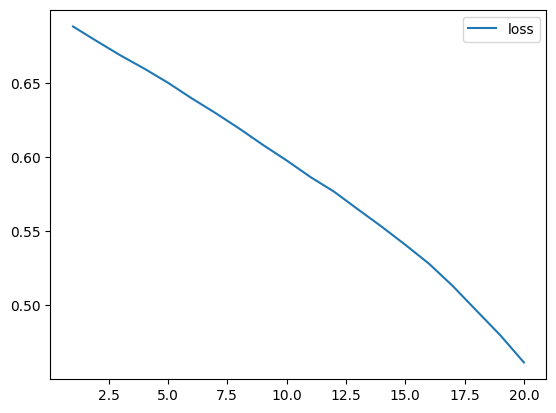

In [ ]:
import matplotlib.pyplot as plt
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

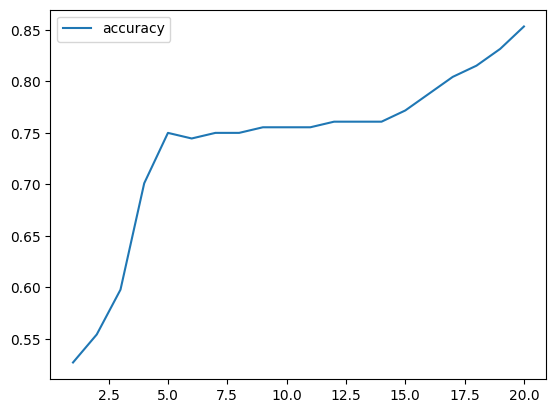

In [ ]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 0.5335 - accuracy: 0.7581 - 158ms/epoch - 79ms/step
Loss: 0.5335307717323303, Accuracy: 0.7580645084381104
